# Project Description

This project introduces the PressureSolver, a computational tool designed to simulate pressure distribution within a reservoir by utilizing the finite difference approach. The solver discretizes and solves the governing equations through the implementation of a tridiagonal matrix technique, enabling more accurate predictions of pressure fields. Notably, the simulated numerical model of the PressureSolver is calibrated against well test data, facilitating the prediction of essential reservoir properties such as size and permeability. Through the amalgamation of numerical simulation and real-world data calibration, this project contributes to a deeper understanding of reservoir dynamics and offers insights into reservoir characterization and management.

In [3]:
import numpy as np
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

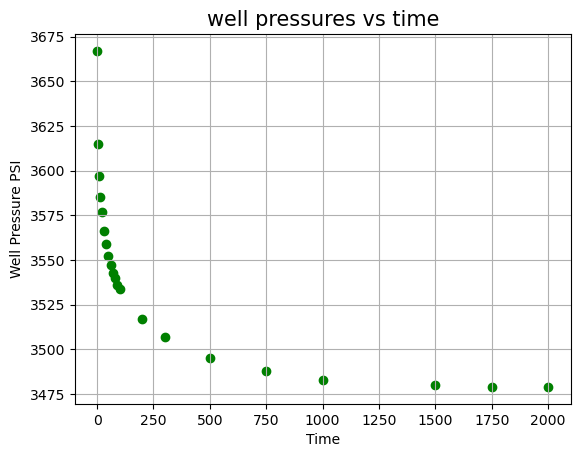

In [6]:
# Importing well test data and visualising it
df = pd.read_csv('C:/Users/donto/Downloads/nnnn/project2/data/well_bhp.dat',sep='\t')
time_data_fm=np.array(df.time)
pressure_data_fm=np.array(df.well_pressure)
plt.scatter(time_data_fm, pressure_data_fm, color="green")
plt.title('well pressures vs time', size=15)
plt.xlabel('Time')
plt.ylabel('Well Pressure PSI')
plt.grid()
plt.show()

In [49]:
def tri_diag(a, b, c, k1=-1, k2=0, k3=1):
  """ a,b,c diagonal terms
    default k-values for 4x4 matrix:
    | b0 c0 0  0 |
    | a0 b1 c1 0 |
    | 0  a1 b2 c2|
    | 0  0  a2 b3|
  """
  return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

# Class Simulator
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in
    a reservoir, logarithmic grid has been used, y = ln(r/rw).

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        Constant time step                   dt         days
        Time final (stopping criteria)       t_final    days
        Well radius                          rw         ft
        Outer reservoir boundary             re         ft
        Height of reservoir                  h          ft
        Absolute permeability                k          mD
        Porosity                             phi        dimensionless
        Fluid viscosity                      mu         mPas (cP)
        Total (rock+fluid) compressibility   ct         1 / psi
        Constant flow rate at well           Q          bbl / day
        Initial reservoir pressure           pi         psi
        -------------------------------------------------------------
    """

    def __init__(self,
                 N,
                 dt,  
                 t_final=1, 
                 well_data="C:/Users/donto/Downloads/nnnn/project2/data/well_bhp.dat", #Need to change to the proper path, if not in the same folder
                 rw=0.318,
                 re=1000.0, 
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 k=500,
                 pi=3900.0, 
                ):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_ # Convert's flow rate to SI units
        self.pi_ = pi*self.psi_to_pa_ # Converts initial pressure to SI units

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_
      
        
        self.alpha_=1

        self.t_final = t_final*self.day_to_sec_

        self.well_data= well_data
        

        #self.data_file = data_file

        # determining coordinates and defining alpha,beta and eta parameters
        self.ye=np.log(self.re_/self.rw_)
        self.deltay=self.ye/self.N_
        self.alpha=self.Q_*self.mu_/(2*np.pi*self.h_ *self.k_)
        self.beta=self.alpha*self.deltay
        self.eta=self.k_/(self.mu_*self.phi_*self.ct_)
        self.y=np.arange(self.N_)*self.deltay+self.deltay/2


        self.xi= self.eta*np.exp(-2*self.y)*self.dt_/(self.rw_**2*self.deltay**2)

        # Defining matrix A
        self.a=-self.xi[1:self.N_]
        self.b=1+2*self.xi
        self.b[0]=1+self.xi[0]
        self.b[-1]=1+3*self.xi[-1]
        self.c=-self.xi[0:self.N_-1]
        self.d= np.zeros(self.N_)
        self.d[0]=self.deltay*self.alpha_

        self.A=tri_diag(self.a, self.b, self.c)

    def solve(self):
      self.pn=np.linalg.solve(self.A, self.d)

    def analytical_linesolution(self, r, t):
      return self.pi_+(self.mu_*self.Q_/(4*np.pi*self.h_*self.k_))*scipy.special.expi(-r**2/(4*self.eta*t))

    def well_pressure(self, p0):
      pw=p0-self.beta/2
      return pw

    def solve_time_analytical_and_numerical(self):
      self.p_old=np.repeat(self.pi_, self.N_)
      self.pw_numerical=[]
      self.time_numerical=[]
      self.pw_analitical=[]
      self.time_analitical=[]
      self.t=0
      self.pw_numerical.append(self.well_pressure(self.p_old[0]))
      self.time_numerical.append(self.t)
      while self.t<self.t_final:
        self.d=np.zeros(self.N_)
        self.d[0]=-self.beta*self.xi[0]
        self.d[-1]=2*self.pi_*self.xi[-1]
        self.d=self.d+self.p_old
        self.solve()
        self.p_old=np.copy(self.pn)
        self.t +=self.dt_
        self.pw_numerical.append(self.well_pressure(self.p_old[0]))
        self.time_numerical.append(self.t)
        self.pw_analitical.append(self.analytical_linesolution(self.rw_,self.t))
        self.time_analitical.append(self.t)
      self.pw_numerical=np.array(self.pw_numerical)
      self.time_numerical=np.array(self.time_numerical)
      self.pw_analitical=np.array(self.pw_analitical)
      self.time_analitical=np.array(self.time_analitical)

    def pw_numerical_optimal(self, time, k_local, re_local): 
      dt_hrs = 1
      hrs_to_sec=60*60
      dt_=dt_hrs*hrs_to_sec

      k_local=k_local*1e-15 / 1.01325
      pi_local=self.pi_
      re_local=re_local*self.ft_to_m_
      time=time*hrs_to_sec
      pw_numerical=[]
      time_numerical=[]
      #
      t=0

      #
      L=np.array([np.log(self.rw_/self.rw_), np.log(re_local/self.rw_)])
      dy=L[1]/self.N_
      y = np.arange(self.N_)*dy +dy/2

      #
      beta_=self.Q_*self.mu_*dy/(2*np.pi*k_local*self.h_)
      nu_=k_local/(self.mu_*self.phi_*self.ct_)
      xi=nu_*np.exp(-2*y)*dt_/(self.rw_**2*dy**2)


      #Determine arrays a,b and c which will form matrix A
      a=-np.delete(xi,0)
      c=-np.delete(xi,-1)
      b=1+2*xi
      b[0]=1+xi[0]
      b[-1]=1+3*xi[-1]
      A=tri_diag(a, b, c)
      p_old=np.repeat(pi_local, self.N_)
      while t<max(time):
        d=np.zeros(self.N_)
        d[0]=-beta_*xi[0]
        d[-1]=2*pi_local*xi[-1]
        d=d+p_old
        pn=np.linalg.solve(A,d)
        if t in time:
          well_pressure=p_old[0]-beta_/2
          pw_numerical.append(well_pressure)
          time_numerical.append(t)
        p_old=np.copy(pn)
        t +=dt_
            
      #We only want to safe wellbore pressure points at the same time points as in given data file    
      if t in time:
        well_pressure=p_old[0]-beta_/2
        pw_numerical.append(well_pressure)
        time_numerical.append(t)
      time_numerical=np.array(time_numerical)
      pw_numerical=np.array(pw_numerical)

      # return pressure in psi
      return pw_numerical/self.psi_to_pa_ 

    # Plotting wells
    def plot_3_different_well_pressure(self):
        df = pd.read_csv(self.well_data,sep='\t')
        x=df.time
        x=np.array(x)
        y=df.well_pressure
        y=np.array(y)
        plt.scatter(x,y, marker='x', color="red", label="Well test data")
        self.solve_time_analytical_and_numerical()
        plt.title("Well pressure comparison: well test data, numerical and analytical")
        plt.scatter(self.time_numerical*24/self.day_to_sec_, self.pw_numerical/self.psi_to_pa_, marker='o', color="blue", label="Numerical N="+str(self.N_))
        plt.scatter(self.time_analitical*24/self.day_to_sec_, self.pw_analitical/self.psi_to_pa_, marker='D', color="green", label="Analytical")
        plt.ylabel("Well pressure, psi")
        plt.xlabel("Time - log scale, hours")
        plt.xscale("log")
        plt.grid()
        plt.legend()
        plt.show()

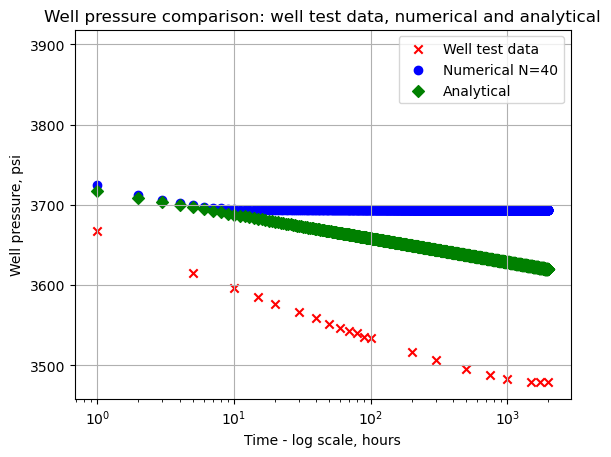

In [50]:
# Plotting comparison between well pressure and numberical model
H1=PressureSolver(N=40, t_final=83, dt=1/24)
H1.solve_time_analytical_and_numerical()
H1.plot_3_different_well_pressure()

In [51]:
# Determining Optimum parameter 
H1=PressureSolver(N=400, dt=1/24, t_final=100)
popt, _ = curve_fit(H1.pw_numerical_optimal, time_data_fm, pressure_data_fm)
print("Optimal parameters are k=" +str(popt[0])+" and re="+str(popt[1]))

Optimal parameters are k=325.7198572972911 and re=25785.253299755896


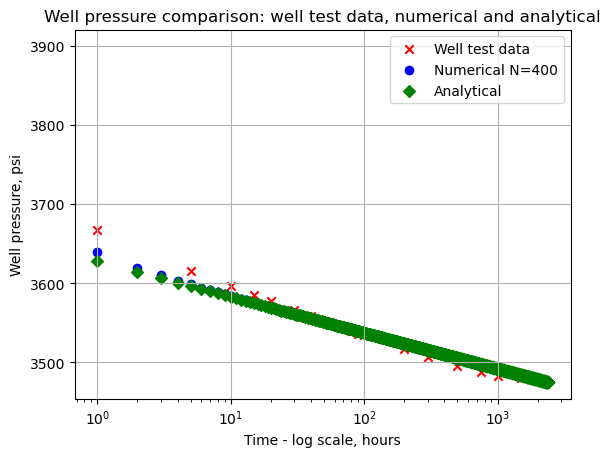

In [52]:
# Plotting optimum parameters to adjust numerical model to well data
H1=PressureSolver(N=400, k=popt[0] , re=popt[1], t_final=100, dt=1/24)
H1.solve_time_analytical_and_numerical()
H1.plot_3_different_well_pressure()

In [53]:
## Volume Computation 
# Units used for calculation is in SI
optimized_re= popt[1]
rw= 0.318*0.3048
pi=3.14
h=11*0.3048
phi= 0.25

total_volume_water= (optimized_re - rw)**2 *pi*h*phi
print("Total_volume_water:", total_volume_water,"m3")

Total_volume_water: 1749914555.7071931 m3
